In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import psycopg2
# import os
# import sqlalchemy
# from sqlalchemy import create_engine
import pipeline_plan_functions.utils.pipe_db_handler as dbh
from python_utils.utils.logger import logger
# import alloc_functions.allocation_scenario as asf
# import alloc_functions.controller as acf
# import alloc_functions.daily as adf
# import alloc_functions.cleanup as cleaner
# import alloc_functions.mixed as mixed
# import pipeline_plan_functions.utils.data_handler as dh
import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
import matplotlib
import json
from pulp import *
fps_colours = ['#004A9C', '#45D281', '#FEC001','#A365E0', '#5B9BD5',

               '#FF0000', '#0563C1', '#954F72']
import plotly.graph_objects as go
mapbox_token = ('pk.eyJ1Ijoic29mZmZ0IiwiYSI6ImNrbmZ0Z3RidzJ5NngycXA5cDNpY2c1ajIifQ.Gi2oP1Z3G5wP6pn7OF5l1A')

In [2]:
def read_routes(comment):
    try:
        cnx = dbh.create_alch_engine()
        sql_query = f"""SELECT route_id, actual_start_time, actual_end_time, number_order,
            distance_miles, site_id_start, site_id_end, vehicle_id FROM t_route_formatted
            WHERE comment = '{comment}'"""
        routes = pd.read_sql_query(sql_query, cnx)
    except (Exception, psycopg2.Error) as error:
        logger.error("Error while fetching telematics")
        raise error
    finally:
        cnx.dispose
    # TODO Check datatypes
    return routes

def get_site_name_dict(client):
    try:
        connection, cur = dbh.database_connection('test')
        sql_query = f"""SELECT site_id, site_name
            FROM t_sites WHERE client_id={client}"""
        cur.execute(sql_query)
        connection.commit()
        site_data = cur.fetchall()
    except (Exception, psycopg2.Error) as error:
        logger.error("Error while fetching site data")
        raise error
    finally:
        cur.close()
        connection.close()
    site_name_dict = {site[0]: site[1]
                       for site in site_data}
    return site_name_dict

# site_id starts
def bar_plot_site_starts(routes, site_dict, site=0):
    grouped = routes.groupby(['site_id_start', 'same_return'])['route_id'].count().unstack(fill_value=0)
    grouped['site_name'] = grouped.index.map(site_dict).fillna('other')
    grouped['n_routes'] = grouped[True] + grouped[False]
    grouped = grouped.sort_values(by='n_routes', ascending=False).reset_index()
    grouped = grouped[grouped['n_routes'] > 5]

    fig, ax = plt.subplots(
        1, figsize=(8, 3), gridspec_kw={'hspace': 0.5})
    ax.set_title(
        f'Vehicles asigned to {site_dict[site]} \n Where do routes start?',
        color=fps_colours[0], fontweight='bold')
    ax.bar(
        x=grouped.index,
        height=grouped[True],
        color=[fps_colours[0]], label='Same return site')
    ax.bar(
        x=grouped.index,
        height=grouped[False], bottom=grouped[True],
        color=[fps_colours[1]], label='Different return site')

    ax.legend(frameon=False, bbox_to_anchor=(1, 0.8))
    ax.set_ylabel('# of routes', color=fps_colours[0])
    ax.set_xlabel('Site', color=fps_colours[0])
    ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(np.arange(len(grouped))))
    ax.set_xticklabels(grouped['site_name'], rotation=45, ha='right')
    # ax.text(x=len(grouped)+2, y=grouped['n_routes'].max()/2, s=f'{len(routes)} Routes')
    n_same_start = sum(routes['start_right_id'])
    ax.text(x=len(grouped)+2, y=grouped['n_routes'].max()/2, s=(
        f"{len(routes)} Routes\n"
        f"{np.round(100*n_same_start/len(routes), 1)}% start on the right site\n"
        f"{np.round(100*routes['same_return'].mean(), 1)}% return to same site"
        ))
    fig.savefig(
        f"sample/hgv/{site_dict[site]}_site_starts.png",
        bbox_inches="tight", dpi=300)
    return

def bar_plot_site_ends(routes, site):
    grouped = routes.groupby(['site_id_end', 'start_right_id'])['route_id'].count().unstack(fill_value=0)
    grouped['site_name'] = grouped.index.map(site_dict).fillna('other')
    for c in [True, False]:
        if c not in grouped.columns:
            grouped[True] = 0
    grouped['n_routes'] = grouped[True] + grouped[False]
    grouped = grouped.sort_values(by='n_routes', ascending=False).reset_index()
    fig, ax = plt.subplots(
        1, figsize=(8, 3), gridspec_kw={'hspace': 0.5})
    ax.set_title(
        f'Routes starting from {site_dict[site]} \n Where do routes end?',
        color=fps_colours[0], fontweight='bold')
    ax.bar(
        x=grouped.index,
        height=grouped[True],
        color=[fps_colours[0]], label=f'Originally from {site_dict[site]}')
    ax.bar(
        x=grouped.index,
        height=grouped[False], bottom=grouped[True],
        color=[fps_colours[1]], label=f'Originally NOT from {site_dict[site]}')

    ax.legend(frameon=False, bbox_to_anchor=(1, 0.8))
    ax.set_ylabel('# of routes', color=fps_colours[0])
    ax.set_xlabel('Site', color=fps_colours[0])
    ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(np.arange(len(grouped))))
    ax.set_xticklabels(grouped['site_name'], rotation=45, ha='right')
    ax.text(x=len(grouped)+2, y=grouped['n_routes'].max()/2, s=(
        f"{len(routes)} Routes\n"
        f"{np.round(100*routes['start_right_id'].mean(), 1)}% originally from site\n"
        f"{np.round(100*routes['same_return'].mean(), 1)}% return to same site"
        ))
    fig.savefig(
        f"sample/hgv/{site_dict[site]}_site_ends.png",
        bbox_inches="tight", dpi=300)
    return

def right_start_site(start_id, site):
    return start_id in site

def histo_variable(df, colname, site=0, upperclip=None, lowerclip=None, bins=10,
                   suff='', vline_dict=None):
    fig, ax = plt.subplots(
        1, figsize=(8, 3), gridspec_kw={'hspace': 0.5})
    ax.set_title(
        f'{site_dict[site]} \n {colname} distribution',
        color=fps_colours[0], fontweight='bold')
    r = ax.hist(
        df[colname].clip(upper=upperclip, lower=lowerclip),
        color=[fps_colours[0]],
        bins=bins)

    ax.set_ylabel('# of routes', color=fps_colours[0])
    ax.set_xlabel(f'{colname}', color=fps_colours[0])
    ax.text(x=r[1][-1]*1.1, y=r[0].max()/2, s=(
        f"{len(df)} entries\n"
        f"Mean: {np.round(df[colname].mean(), 1)}\n"
        f"Max: {np.round(df[colname].max(), 1)}\n"
        f"{np.round((df[colname] > upperclip).mean()*100, 1)}% over threshold {upperclip}\n"
        f"{np.round((df[colname] < lowerclip).mean()*100, 1)}% under threshold {lowerclip}"
        ))
    if vline_dict:
        for i, key in enumerate(vline_dict.keys()):
            ax.axvline(x=vline_dict[key], label=key,
                       color=fps_colours[(i+1)%len(fps_colours)])
        ax.legend(frameon=False)
    fig.savefig(
        f"sample/hgv/{site_dict[site]}_histo_{colname}{suff}.png",
        bbox_inches="tight", dpi=300)
    return

def read_telematics(runs, con):
    COLS = ['departure_time', 'departure_location', 'arrival_time',
        'arrival_location', 'distance_miles', 'driving_time',
        'vehicle_id', 'journey_node_id', 'route_id', 'run', 'client_id',
        'departure_site_id', 'arrival_site_id', 'site_id']
    try:
        cols_telematics = ", ".join(COLS)
        sql_query = f"""SELECT {cols_telematics} FROM t_telematics
            WHERE run IN {runs}"""
        telematics = pd.read_sql_query(sql_query, con)
    except (Exception, psycopg2.Error) as error:
        logger.error("Error while fetching telematics")
        raise error
    # TODO Check datatypes
    # telematics['distance_miles'] = telematics['distance_miles'].clip(lower=0)
    return telematics

def bar_plot_vehicle_sites(routes, site_dict, site_veh_count):
    grouped = routes.groupby(['site_id_start', 'vehicle_id']).count()[['route_id', 'distance_miles']]
    grouped = grouped.groupby('site_id_start').count()
    grouped['site_name'] = grouped.index.map(site_dict).fillna('other')
    grouped = grouped.merge(site_veh_count, left_index=True, right_index=True, how='left')
    grouped = grouped.reset_index()
    # print(grouped.head())
    fig, ax = plt.subplots(
        1, figsize=(8, 3), gridspec_kw={'hspace': 0.5})
    ax.set_title(
        f'Vehicle locations',
        color=fps_colours[0], fontweight='bold')
    ax.bar(
        x=grouped.index-0.2,
        height=grouped['route_id'], width=0.5,
        color=[fps_colours[0]], label='According to route starts')
    ax.bar(
        x=grouped.index,
        height=grouped['vehicle_id'], width=0.5,
        color=[fps_colours[1]], label='According to microlise groups')

    ax.legend(frameon=False, bbox_to_anchor=(1, 0.8))
    ax.set_ylabel('# of vehicles', color=fps_colours[0])
    ax.set_xlabel('Site', color=fps_colours[0])
    ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(np.arange(len(grouped))))
    ax.set_xticklabels(grouped['site_name'], rotation=45, ha='right')
    n_veh = len(routes['vehicle_id'].unique())
    ax.text(x=len(grouped)+2, y=grouped['route_id'].max()/2,
            s=f'{n_veh} vehicles in total')
    fig.savefig(
        f"sample/hgv/where_vehicles_work.png",
        bbox_inches="tight", dpi=300)
    return


In [5]:
comment = "HGV repated 2022-05-31 10:23"
routes = read_routes(comment)
routes.sort_values(by='actual_start_time', inplace=True)
site_dict = get_site_name_dict(2)
site_dict[0] = 'All Sites'
sheet_list = pd.read_csv(r'C:\Users\SofiaTaylor\OneDrive - Flexible Power Systems Ltd\dev\fps_pipeline_plan\functions\shared_functions\telematics\sample\hgv\telematics_check.csv')
crick_entries = sheet_list['site_id'] == 304
sheet_list.loc[crick_entries, 'site_id'] = 13
site_veh_count = sheet_list.groupby('site_id')['vehicle_id'].count()
vehicles = sheet_list['vehicle_id'].unique()
vehicle_site_dict = {v: sheet_list[sheet_list['vehicle_id'] == v]['site_id'].values for v in vehicles}
routes['site_ids'] = routes['vehicle_id'].map(vehicle_site_dict)
routes['same_return'] = routes['site_id_start'] == routes['site_id_end']
routes['start_right_id'] = False

for idx in routes.index:
    routes.loc[idx, 'start_right_id'] = right_start_site(
        routes.loc[idx, 'site_id_start'], routes.loc[idx, 'site_ids'])
other_sites = [27, 29, 30, 31, -9999]
routes = routes[~routes['site_id_start'].isin(other_sites)]
routes['duration_hours'] = (routes['actual_end_time'] - routes['actual_start_time']).dt.total_seconds()/3600
routes['date'] = routes['actual_start_time'].dt.date
routes['start_time'] = (routes['actual_start_time'] - dt.datetime(2022, 1, 1)).dt.total_seconds()/3600 % 24
routes['end_time'] = (routes['actual_end_time'] - dt.datetime(2022, 1, 1)).dt.total_seconds()/3600 % 24


In [14]:
duty_wait_time = dt.timedelta(hours=6)
cleaned_routes = routes[
    (routes['duration_hours'] <= 10)
    & (routes['distance_miles'] <= 400)].copy()
cleaned_routes.sort_values(by=['vehicle_id', 'actual_start_time'],
                        inplace=True)
cleaned_routes['prev_wait_time'] = (cleaned_routes['actual_start_time']
                                    - cleaned_routes['actual_end_time'].shift(1))
cleaned_routes['client_id'] = 3
cleaned_routes['source'] = 1
cleaned_routes['new_vehicle'] = cleaned_routes['vehicle_id'] != cleaned_routes['vehicle_id'].shift(1)
cleaned_routes['new_duties'] = ((cleaned_routes['new_vehicle'])
                                | (cleaned_routes['prev_wait_time'] > duty_wait_time))
cleaned_routes['duty_id'] = cleaned_routes['new_duties'].cumsum()
cleaned_routes.rename(columns={'actual_start_time': 'departure_time', 'actual_end_time': 'arrival_time'}, inplace=True)
daily_duties = cleaned_routes.groupby(['duty_id']).agg({
    'departure_time': 'min',
    'site_id_start': ['first', 'nunique'],
    'distance_miles': 'sum',
    'duration_hours': 'sum',
    'number_order': 'sum',
    'arrival_time': 'last',
    'route_id': 'count'})
daily_duties.columns = ['departure_time', 'site_id_start', 'number_sites', 'distance_miles',
                        'duration_hours', 'number_order', 'arrival_time', 'n_routes']

### All sites

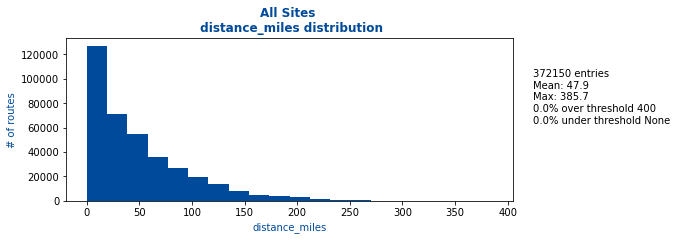

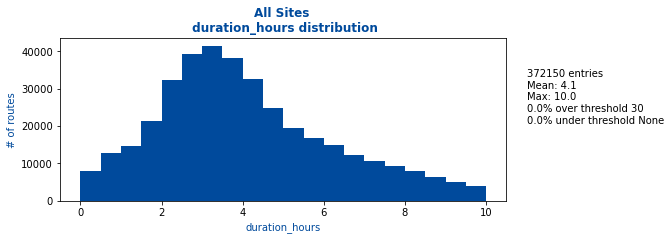

In [9]:
## All sites

# bar_plot_site_starts(routes, site_dict, site=0)
histo_variable(cleaned_routes, 'distance_miles', upperclip=400, bins=20, suff='_cleaned2')
histo_variable(cleaned_routes, 'duration_hours',
               upperclip=30, bins=20, suff='_cleaned2'
               )
# histo_variable(routes, 'number_order',
#                upperclip=15, bins=15
#                )
# bar_plot_vehicle_sites(routes, site_dict, site_veh_count)
# daily_routes = routes.groupby('date').agg({'route_id': 'count', 'distance_miles': 'sum'})
# daily_routes.rename(columns={'route_id': 'routes_per_day'}, inplace=True)
# histo_variable(daily_routes, 'routes_per_day', bins=20
#                )
# histo_variable(routes, 'start_time', site=0, bins=24)
# histo_variable(routes, 'end_time', site=0, bins=24)

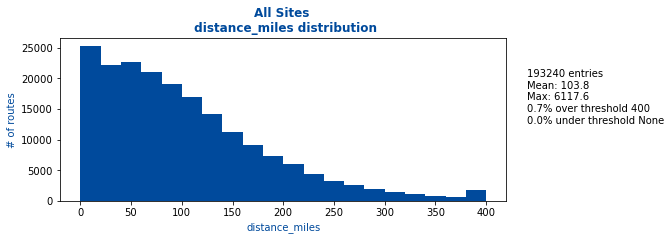

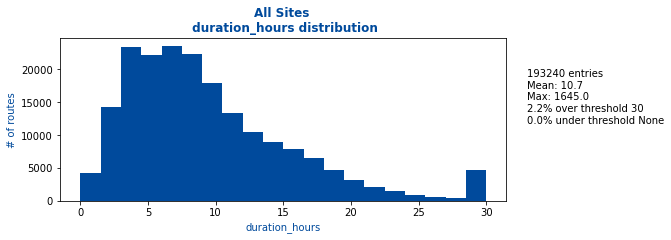

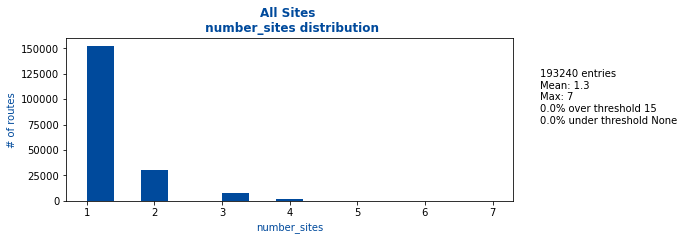

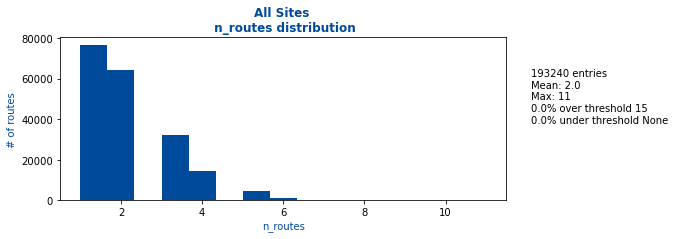

In [11]:
## All sites duties

histo_variable(daily_duties, 'distance_miles', upperclip=400, bins=20, suff='duties')
histo_variable(daily_duties, 'duration_hours', suff='duties',
               upperclip=30, bins=20
               )
histo_variable(daily_duties, 'number_sites', suff='duties',
               upperclip=15, bins=15,
               )
histo_variable(daily_duties, 'n_routes',
               upperclip=15, bins=15, suff='duties'
               )

### Site Specific

Site: Waltham Point DC
Daily duties starting on site: 18680
          76.0 % routes are single site
          74.7 % of total are good


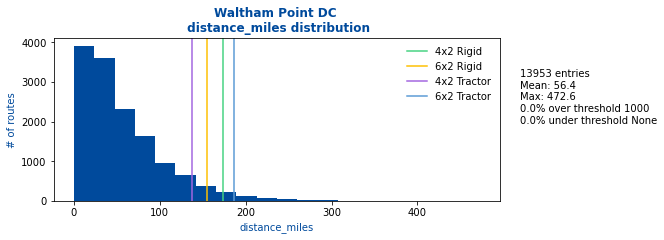

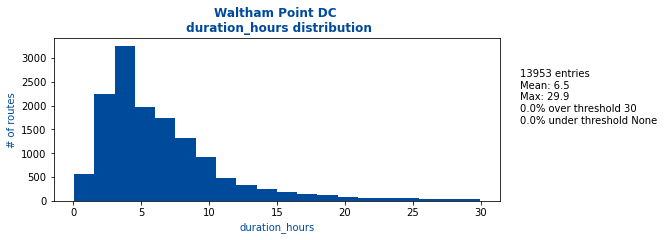

In [66]:
sites_dc = site_veh_count.index
plt.close('all')

for site in sites_dc[:1]:
    # Where do routes end
    # routes_from_site = routes[routes['site_id_start'] == site]
    # if len(routes_from_site) > 0:
    #     bar_plot_site_ends(routes_from_site, site)

    # # Plot where do routes start for vehicles belonging to a site
    # routes_vehicle_site = routes[routes['site_ids'].apply(lambda x: site in x)]
    # bar_plot_site_starts(routes_vehicle_site, site_dict, site)
    ## Site histos

    routes_site = routes[
        (routes['site_id_start'] == site)
        & (routes['site_id_end'] == site)
        & (routes['duration_hours'] <= 10)
        & (routes['distance_miles'] <= 400)].copy()
    routes_site.sort_values(by=['vehicle_id', 'actual_start_time'],
                            inplace=True)


    routes_site['prev_wait_time'] = (routes_site['actual_start_time']
                                    - routes_site['actual_end_time'].shift(1))

    routes_site['new_vehicle'] = routes_site['vehicle_id'] != routes_site['vehicle_id'].shift(1)
    routes_site['new_duties'] = ((routes_site['new_vehicle'])
                                | (routes_site['prev_wait_time'] > duty_wait_time))
    routes_site['duty_id'] = routes_site['new_duties'].cumsum()

    # daily_routes_site = routes_site.groupby('date').agg({'route_id': 'count', 'distance_miles': 'sum'})
    # daily_routes_site.rename(columns={'route_id': 'routes_per_day'}, inplace=True)
    # histo_variable(routes_site, 'distance_miles', site, upperclip=400, bins=20)
    # histo_variable(routes_site, 'duration_hours', site,
    #             upperclip=30, bins=20
    #             )
    # histo_variable(routes_site, 'number_order', site,
    #             upperclip=15, bins=8
    #             )

    # histo_variable(daily_routes_site, 'routes_per_day', site, bins=30
    #             )
    # histo_variable(routes_site, 'start_time', site=site, bins=24)
    # histo_variable(routes_site, 'end_time', site=site, bins=24)
    daily_duties_site = daily_duties[
        (daily_duties['site_id_start'] == site)
        & (daily_duties['number_sites'] == 1)
        & (daily_duties['duration_hours'] <= 30)
        & (daily_duties['distance_miles'] <= 1000)
        ]
    daily_duties_site_all = len(daily_duties[(daily_duties['site_id_start'] == site)])

    duties_single_site = len(daily_duties[(daily_duties['site_id_start'] == site)
                                        & (daily_duties['number_sites'] == 1)])
    duties_site_good = len(daily_duties_site)/daily_duties_site_all
    fig1 = histo_variable(
        daily_duties_site, 'distance_miles', site, upperclip=1000,
        bins=20, suff='duty2', vline_dict={
            '4x2 Rigid': 174,
            '6x2 Rigid': 155,
            '4x2 Tractor': 137,
            '6x2 Tractor': 186})
    fig2 = histo_variable(
        daily_duties_site, 'duration_hours', site, suff='duty2',
        upperclip=30, bins=20)
    # histo_variable(daily_duties_site, 'number_order', site, suff='duty2',
    #             upperclip=15, bins=8
    #             )
    # histo_variable(daily_duties_site, 'n_routes', site, suff='duty2',
    #             #    upperclip=15, bins=8
    #             )
    single_site_pc = np.round(100*duties_single_site/daily_duties_site_all, 1)
    print('Site:', site_dict[site])
    print(f"""Daily duties starting on site: {daily_duties_site_all}
          {single_site_pc} % routes are single site
          {np.round(100*duties_site_good, 1)} % of total are good""")
    # plt.close('all')

In [46]:
    plt.close('all')

In [ ]:
daily__site_duties = routes_site.groupby(['duty_id']).agg({
    'actual_start_time': 'min',
    'site_id_start': 'first',
    'distance_miles': 'sum',
    'duration_hours': 'sum',
    'number_order': 'sum',
    'actual_end_time': 'last',
    'route_id': 'count'})
# daily__site_duties.columns = ['actual_start_time', 'site_id_start', 'number_sites', 'distance_miles',
#                         'duration_hours', 'number_order', 'actual_end_time', 'n_routes']

### Telematics

In [43]:
routes[routes['duration'] > 20].sort_values(by='duration')

KeyError: 'duration'

In [ ]:
cnx = dbh.create_alch_engine()
telematics = read_telematics('(44)', cnx)

In [ ]:
route_tel = telematics[telematics['route_id'] == 1090683].copy()
duration = (route_tel['arrival_time'] - route_tel['departure_time']
            ).dt.total_seconds()/3600
route_tel['not_long'] = ~((route_tel['distance_miles'] > 20)
                      & (duration > 1))
route_tel.head()

,departure_time,departure_location,arrival_time,arrival_location,distance_miles,driving_time,vehicle_id,journey_node_id,route_id,run,client_id,departure_site_id,arrival_site_id,site_id,not_long
1036302,2022-02-13 13:11:46,Thameside DC,2022-02-13 16:34:33,Argos Kettering,0.198881,0.076111,2716,12587211,1090683,44,3,12,27,12,True
1036303,2022-02-14 11:17:56,Argos Kettering,2022-02-14 11:20:07,Argos Kettering,0.080796,0.036389,2716,12587212,1090683,44,3,27,27,12,True
1036304,2022-02-15 13:17:35,Argos Kettering,2022-02-15 13:21:58,Argos Kettering,0.478558,0.073056,2716,12587213,1090683,44,3,27,27,12,True
1036305,2022-02-16 15:02:32,Argos Kettering,2022-02-16 15:31:12,Argos Kettering,0.000000,0.436667,2716,12587214,1090683,44,3,27,27,12,True
1036306,2022-02-17 11:18:49,Argos Kettering,2022-02-17 11:20:57,Argos Kettering,0.198881,0.035556,2716,12587215,1090683,44,3,27,27,12,True
